In [15]:
import jsonlines
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import nltk
import string
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

In [16]:
# Device configuration (use GPU if available)
device = torch.device("mps" if torch.mps.is_available() else "cpu")

In [2]:
import jsonlines
import pandas as pd

def load_jsonl(file_path):
    data = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            data.append(obj)
    return pd.DataFrame(data)

train_df = pd.read_csv("/Users/devanshk/Desktop/CSI5386-NLP/A2-NLP/SubtaskA/train_df.csv")
test_df = load_jsonl("/Users/devanshk/Desktop/CSI5386-NLP/A2-NLP/SubtaskA/SemEval 2024 Task 8 Monolingual.jsonl")

print(train_df.head())
print(train_df["label"].value_counts())

                                                text  label    model   source  \
0  Forza Motorsport is a popular racing game that...      1  chatGPT  wikihow   
1  Buying Virtual Console games for your Nintendo...      1  chatGPT  wikihow   
2  Windows NT 4.0 was a popular operating system ...      1  chatGPT  wikihow   
3  How to Make Perfume\n\nPerfume is a great way ...      1  chatGPT  wikihow   
4  How to Convert Song Lyrics to a Song'\n\nConve...      1  chatGPT  wikihow   

   id  punctuation_count  avg_sentence_length  perplexity  
0   0                 82            11.305556   10.648826  
1   1                132            10.014706    7.353057  
2   2                153            10.144444    7.753972  
3   3                152            12.059701    7.754606  
4   4                 89            13.547619    7.842487  
label
0    63351
1    56406
Name: count, dtype: int64


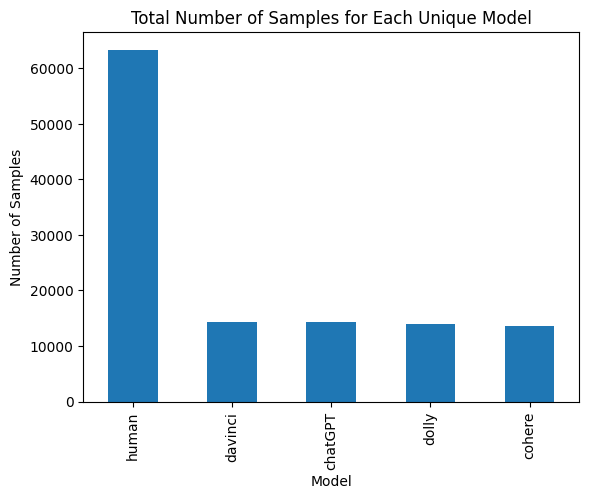

In [3]:
train_df["model"].unique()
# Count the number of samples for each unique model
model_counts = train_df["model"].value_counts()

# Plot the counts
model_counts.plot(kind='bar')
plt.xlabel('Model')
plt.ylabel('Number of Samples')
plt.title('Total Number of Samples for Each Unique Model')
plt.show()

In [4]:
# Separate human and model-generated texts
human_texts = train_df[train_df['model'] == 'human']['text']
model_texts = train_df[train_df['model'] != 'human']['text']

# Initialize CountVectorizer
vectorizer = CountVectorizer(max_features=20)

# Fit and transform the human texts
human_word_counts = vectorizer.fit_transform(human_texts)
human_words = vectorizer.get_feature_names_out()
human_word_freq = np.asarray(human_word_counts.sum(axis=0)).flatten()

# Fit and transform the model texts
model_word_counts = vectorizer.fit_transform(model_texts)
model_words = vectorizer.get_feature_names_out()
model_word_freq = np.asarray(model_word_counts.sum(axis=0)).flatten()

# Create DataFrames for better visualization
human_word_df = pd.DataFrame({'word': human_words, 'frequency': human_word_freq})
model_word_df = pd.DataFrame({'word': model_words, 'frequency': model_word_freq})

# Sort by frequency
human_word_df = human_word_df.sort_values(by='frequency', ascending=False)
model_word_df = model_word_df.sort_values(by='frequency', ascending=False)

print("Most frequent words in human texts:")
print(human_word_df)

print("\nMost frequent words in model-generated texts:")
print(model_word_df)

Most frequent words in human texts:
    word  frequency
13   the    2197117
9     of    1057889
15    to     993976
0    and     966727
6     in     758050
18   you     540146
7     is     408397
12  that     345982
5    for     343656
19  your     334477
8     it     301881
17  with     274541
2     as     270524
10    on     269361
11    or     240726
1    are     215630
3     be     212138
16   was     196031
4     by     187609
14  this     182426

Most frequent words in model-generated texts:
    word  frequency
13   the    1340995
9     of     592855
0    and     578589
15    to     541011
6     in     362139
7     is     252447
5    for     184661
12  that     180554
18   you     164854
8     it     146033
19  your     140137
17  with     133300
10    on     128435
2     as     122864
14  this     116820
3     be     107203
4    can      95677
1    are      95522
16   was      88931
11    or      87084


In [5]:
train_df.head()

,text,label,model,source,id,punctuation_count,avg_sentence_length,perplexity
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,0,82,11.305556,10.648826
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,1,132,10.014706,7.353057
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,2,153,10.144444,7.753972
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,3,152,12.059701,7.754606
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,4,89,13.547619,7.842487


[nltk_data] Downloading package punkt to /Users/devanshk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


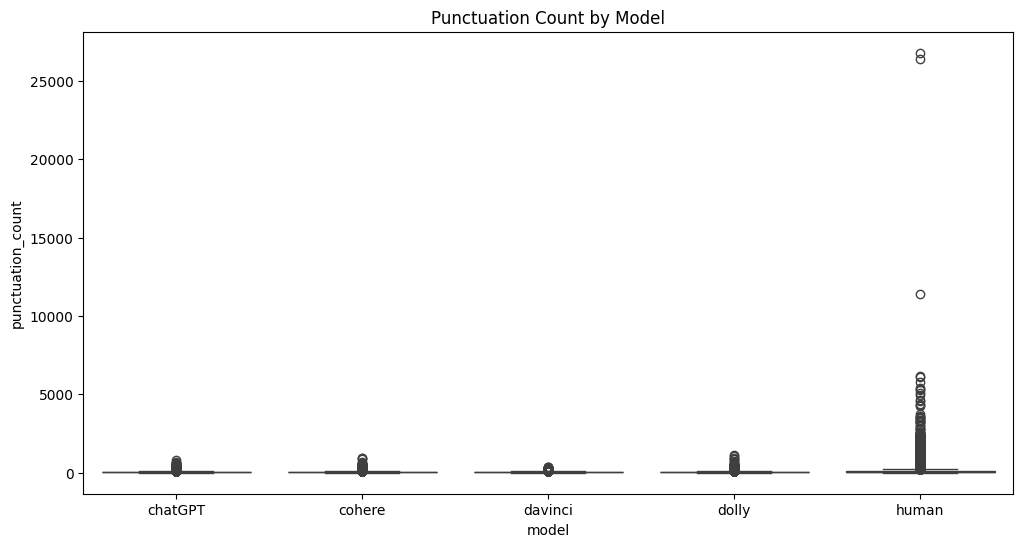

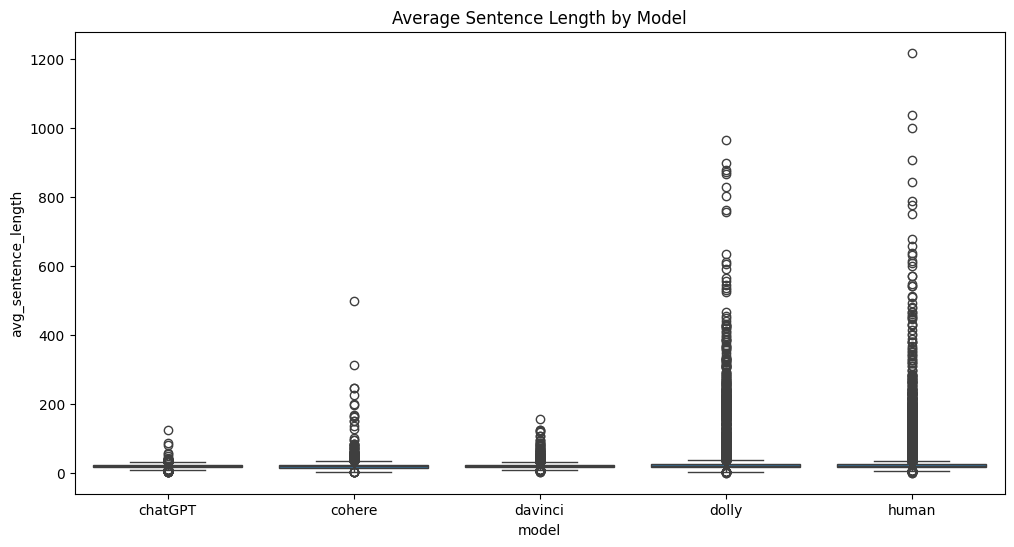

In [25]:
# LM-generated text tends to be more neutral and less emotional compared to human-written text, which often uses punctuation and grammar to convey subjective feelings
# https://cacm.acm.org/research/the-science-of-detecting-llm-generated-text/
# Download the punkt tokenizer for sentence splitting
nltk.download('punkt')

# Function to count punctuation
def count_punctuation(text):
    return sum(1 for char in text if char in string.punctuation)

# Function to calculate average sentence length
def avg_sentence_length(text):
    sentences = nltk.sent_tokenize(text)
    if len(sentences) == 0:
        return 0
    return sum(len(sentence.split()) for sentence in sentences) / len(sentences)

# Add new feature columns to the dataframe
# train_df['punctuation_count'] = train_df['text'].apply(count_punctuation)
# train_df['avg_sentence_length'] = train_df['text'].apply(avg_sentence_length)

# Visualize the differences between human and other models

# Plot punctuation count
plt.figure(figsize=(12, 6))
sns.boxplot(x='model', y='punctuation_count', data=train_df)
plt.title('Punctuation Count by Model')
plt.show()

# Plot average sentence length
plt.figure(figsize=(12, 6))
sns.boxplot(x='model', y='avg_sentence_length', data=train_df)
plt.title('Average Sentence Length by Model')
plt.show()

In [26]:
#Adding perplexity score for each text why: https://www.comet.com/site/blog/perplexity-for-llm-evaluation/
# The follwoing code is take from the above link
model = AutoModelForCausalLM.from_pretrained("gpt2")
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# Load the model and tokenizer (e.g., GPT-2)
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

if torch.backends.mps.is_available():
    device = torch.device("mps")
    model.to(device)
else:
    device = torch.device("cpu")
print(f"The device used is: {device}")
# Assign the EOS token as the padding token
tokenizer.pad_token = tokenizer.eos_token

def calculate_perplexity(text):
    # Tokenize the input text and add batch dimension
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    # Pass the input through the model to get logits
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Shift the logits and input_ids to align targets correctly
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()

    # Compute log probabilities
    log_probs = torch.nn.functional.log_softmax(shift_logits, dim=-1)

    # Gather the log probabilities for the correct tokens
    target_log_probs = log_probs.gather(dim=-1, index=shift_labels.unsqueeze(-1)).squeeze(-1)

    # Mask out positions corresponding to padding tokens
    target_log_probs = target_log_probs * attention_mask[:, 1:].to(log_probs.dtype)

    # Compute the mean negative log-likelihood for the sequence
    negative_log_likelihood = -target_log_probs.sum() / attention_mask[:, 1:].sum()

    # Compute perplexity for the sequence
    perplexity = torch.exp(negative_log_likelihood).item()

    return perplexity

The device used is: mps


In [11]:
# Calculate perplexity for each text in the training dataframe
train_df['perplexity'] = train_df['text'].apply(calculate_perplexity)
# Display the dataframe with the new perplexity column
print(train_df.head())

                                                text  label    model   source  \
0  Forza Motorsport is a popular racing game that...      1  chatGPT  wikihow   
1  Buying Virtual Console games for your Nintendo...      1  chatGPT  wikihow   
2  Windows NT 4.0 was a popular operating system ...      1  chatGPT  wikihow   
3  How to Make Perfume\n\nPerfume is a great way ...      1  chatGPT  wikihow   
4  How to Convert Song Lyrics to a Song'\n\nConve...      1  chatGPT  wikihow   

   id  punctuation_count  avg_sentence_length  perplexity  
0   0                 82            11.305556   10.648826  
1   1                132            10.014706    7.353057  
2   2                153            10.144444    7.753972  
3   3                152            12.059701    7.754606  
4   4                 89            13.547619    7.842487  


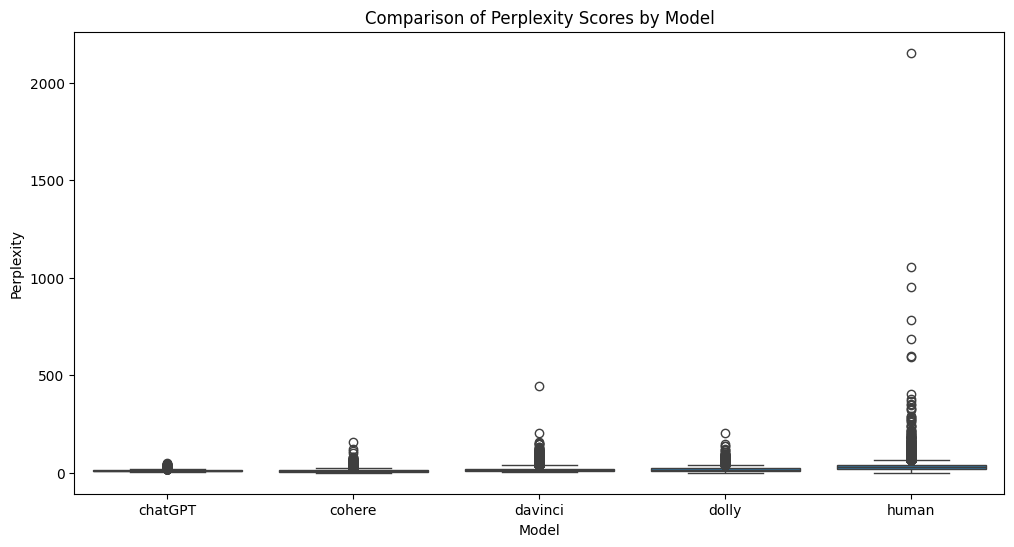

In [13]:
# Plot the comparison of perplexity scores of different models
plt.figure(figsize=(12, 6))
sns.boxplot(x='model', y='perplexity', data=train_df)
plt.title('Comparison of Perplexity Scores by Model')
plt.xlabel('Model')
plt.ylabel('Perplexity')
plt.show()

/var/folders/bk/46wnp9s10t9g39x_n6dfykjh0000gn/T/ipykernel_76554/6283446.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df['punctuation_count'], ax=axes[0, 1], shade=True)
/var/folders/bk/46wnp9s10t9g39x_n6dfykjh0000gn/T/ipykernel_76554/6283446.py:20: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df['avg_sentence_length'], ax=axes[1, 1], shade=True)
/var/folders/bk/46wnp9s10t9g39x_n6dfykjh0000gn/T/ipykernel_76554/6283446.py:23: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df['perplexity'], ax=axes[2, 1], shade=True)


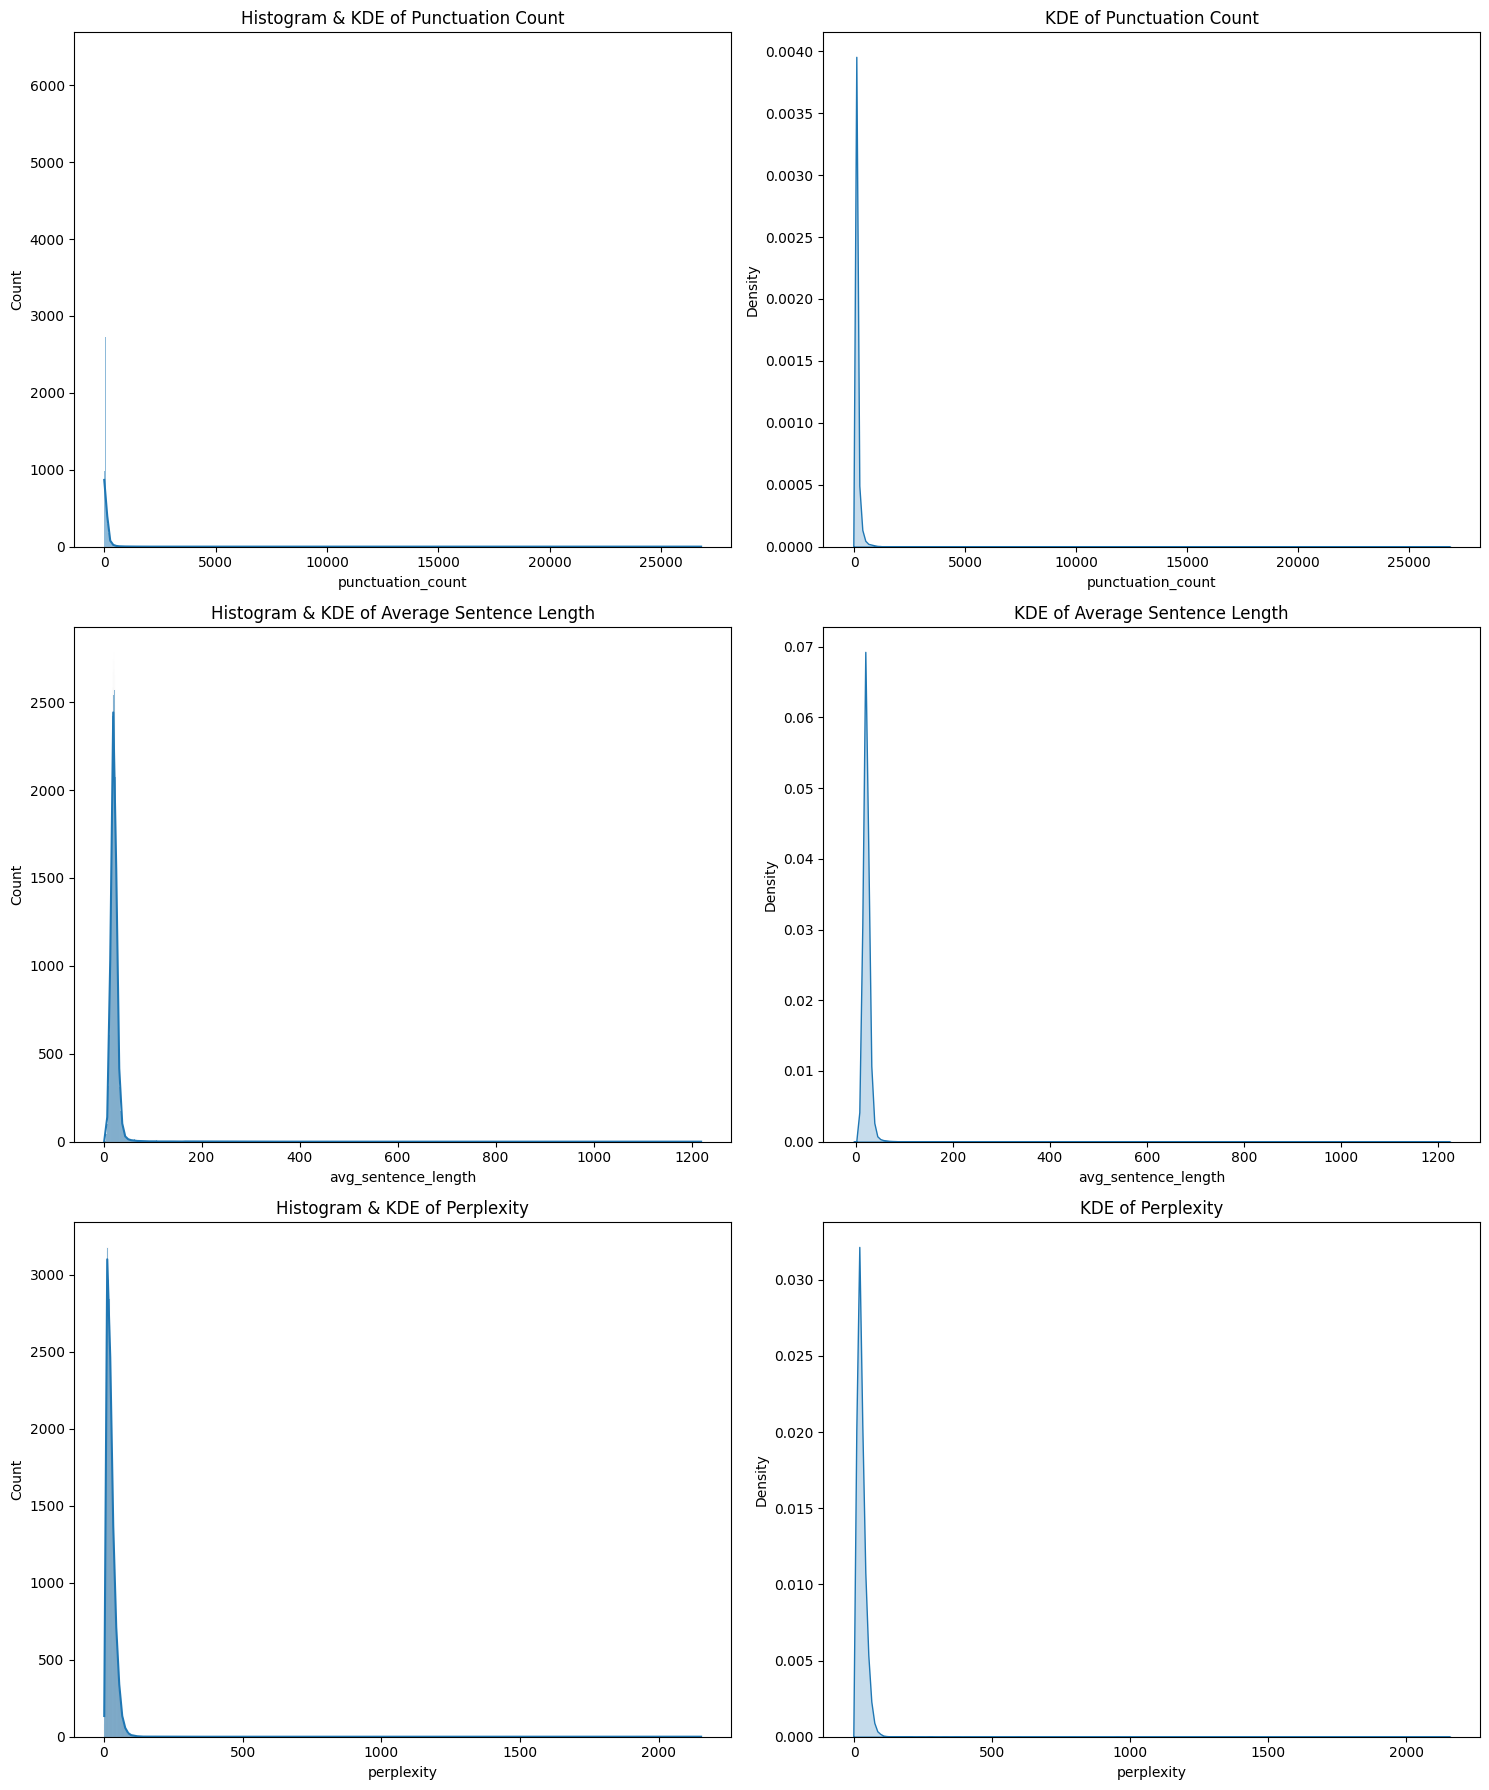

In [15]:
# Plot Histogram & KDE plots for punctuation_count, avg_sentence_length, and perplexity
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Punctuation Count
sns.histplot(train_df['punctuation_count'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Histogram & KDE of Punctuation Count')

# Average Sentence Length
sns.histplot(train_df['avg_sentence_length'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Histogram & KDE of Average Sentence Length')

# Perplexity
sns.histplot(train_df['perplexity'], kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Histogram & KDE of Perplexity')

# KDE plots
sns.kdeplot(train_df['punctuation_count'], ax=axes[0, 1], shade=True)
axes[0, 1].set_title('KDE of Punctuation Count')

sns.kdeplot(train_df['avg_sentence_length'], ax=axes[1, 1], shade=True)
axes[1, 1].set_title('KDE of Average Sentence Length')

sns.kdeplot(train_df['perplexity'], ax=axes[2, 1], shade=True)
axes[2, 1].set_title('KDE of Perplexity')

plt.tight_layout()
plt.show()

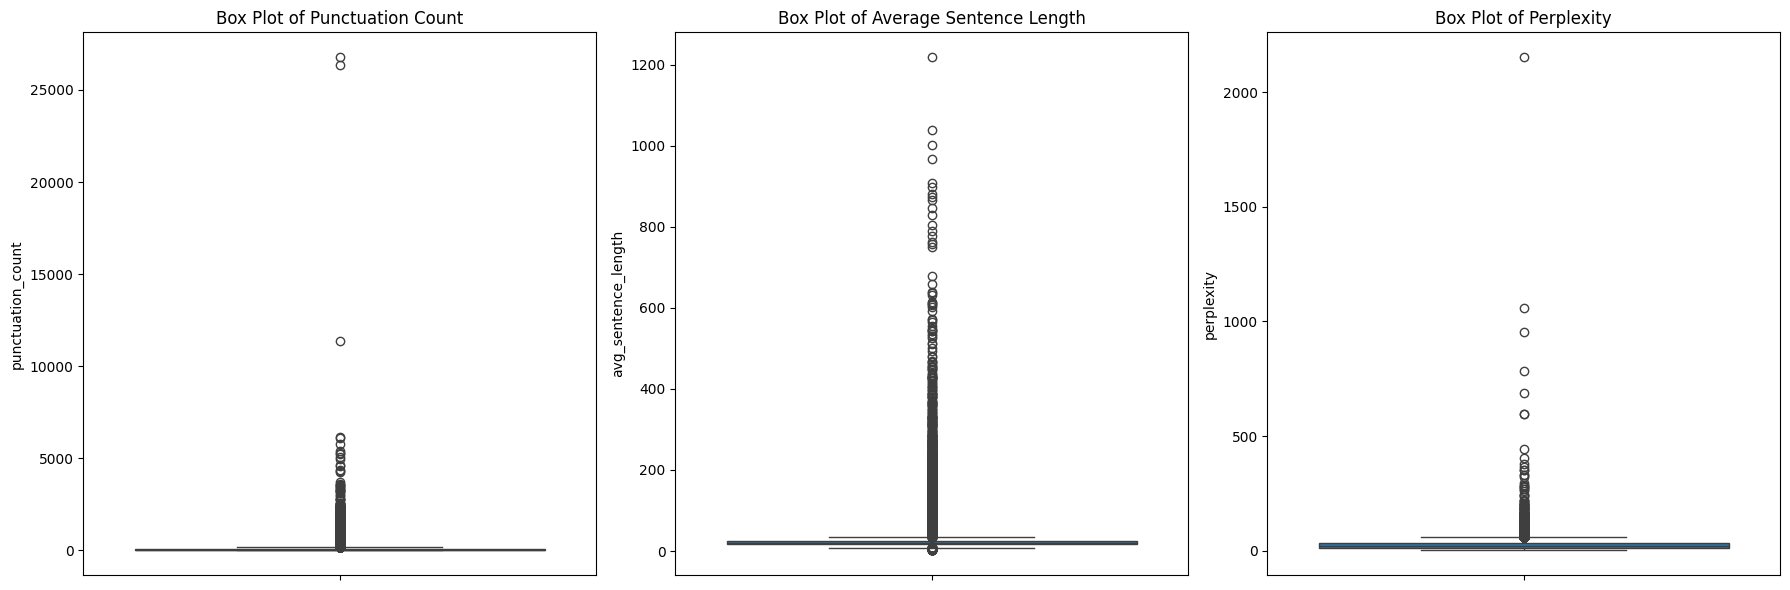

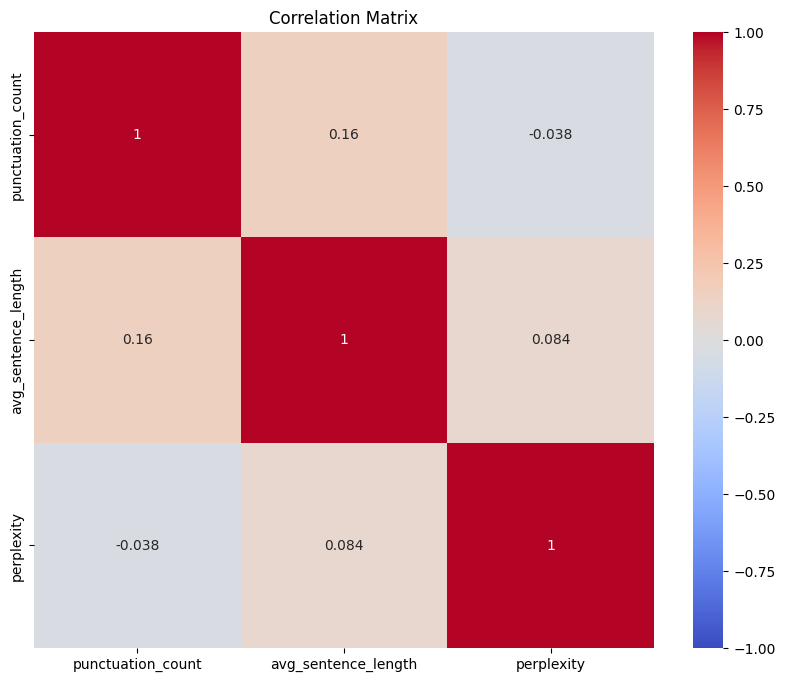

In [16]:
# Plot box plots to check for outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Box plot for punctuation count
sns.boxplot(y='punctuation_count', data=train_df, ax=axes[0])
axes[0].set_title('Box Plot of Punctuation Count')

# Box plot for average sentence length
sns.boxplot(y='avg_sentence_length', data=train_df, ax=axes[1])
axes[1].set_title('Box Plot of Average Sentence Length')

# Box plot for perplexity
sns.boxplot(y='perplexity', data=train_df, ax=axes[2])
axes[2].set_title('Box Plot of Perplexity')

plt.tight_layout()
plt.show()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = train_df[['punctuation_count', 'avg_sentence_length', 'perplexity']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

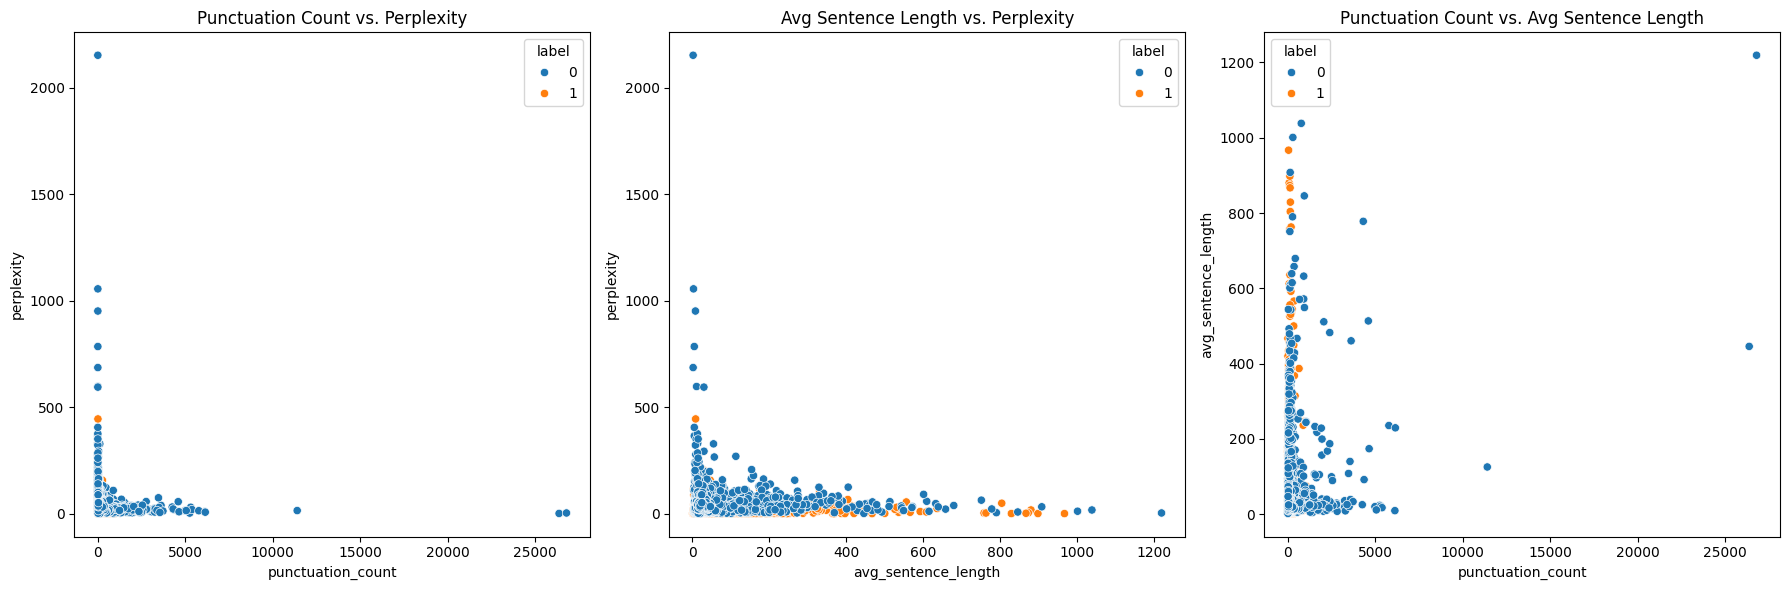

In [17]:
# Scatter plots of punctuation_count vs. perplexity and other feature pairs color-coded by label
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Scatter plot for punctuation_count vs. perplexity
sns.scatterplot(x='punctuation_count', y='perplexity', hue='label', data=train_df, ax=axes[0])
axes[0].set_title('Punctuation Count vs. Perplexity')

# Scatter plot for avg_sentence_length vs. perplexity
sns.scatterplot(x='avg_sentence_length', y='perplexity', hue='label', data=train_df, ax=axes[1])
axes[1].set_title('Avg Sentence Length vs. Perplexity')

# Scatter plot for punctuation_count vs. avg_sentence_length
sns.scatterplot(x='punctuation_count', y='avg_sentence_length', hue='label', data=train_df, ax=axes[2])
axes[2].set_title('Punctuation Count vs. Avg Sentence Length')

plt.tight_layout()
plt.show()

In [6]:
# Apply log transformation
train_df['log_punctuation_count'] = np.log1p(train_df['punctuation_count'])
train_df['log_avg_sentence_length'] = np.log1p(train_df['avg_sentence_length'])
train_df['log_perplexity'] = np.log1p(train_df['perplexity'])

# Display the dataframe with the new log-transformed columns
print(train_df[['log_punctuation_count', 'log_avg_sentence_length', 'log_perplexity']].head())

   log_punctuation_count  log_avg_sentence_length  log_perplexity
0               4.418841                 2.510051        2.455205
1               4.890349                 2.399231        2.122628
2               5.036953                 2.410941        2.169507
3               5.030438                 2.569531        2.169580
4               4.499810                 2.677427        2.179568


/var/folders/bk/46wnp9s10t9g39x_n6dfykjh0000gn/T/ipykernel_56838/2722380637.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df['log_punctuation_count'], ax=axes[0, 1], shade=True)
/var/folders/bk/46wnp9s10t9g39x_n6dfykjh0000gn/T/ipykernel_56838/2722380637.py:19: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df['log_avg_sentence_length'], ax=axes[1, 1], shade=True)
/var/folders/bk/46wnp9s10t9g39x_n6dfykjh0000gn/T/ipykernel_56838/2722380637.py:22: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_df['perplexity'], ax=axes[2, 1], shade=True)


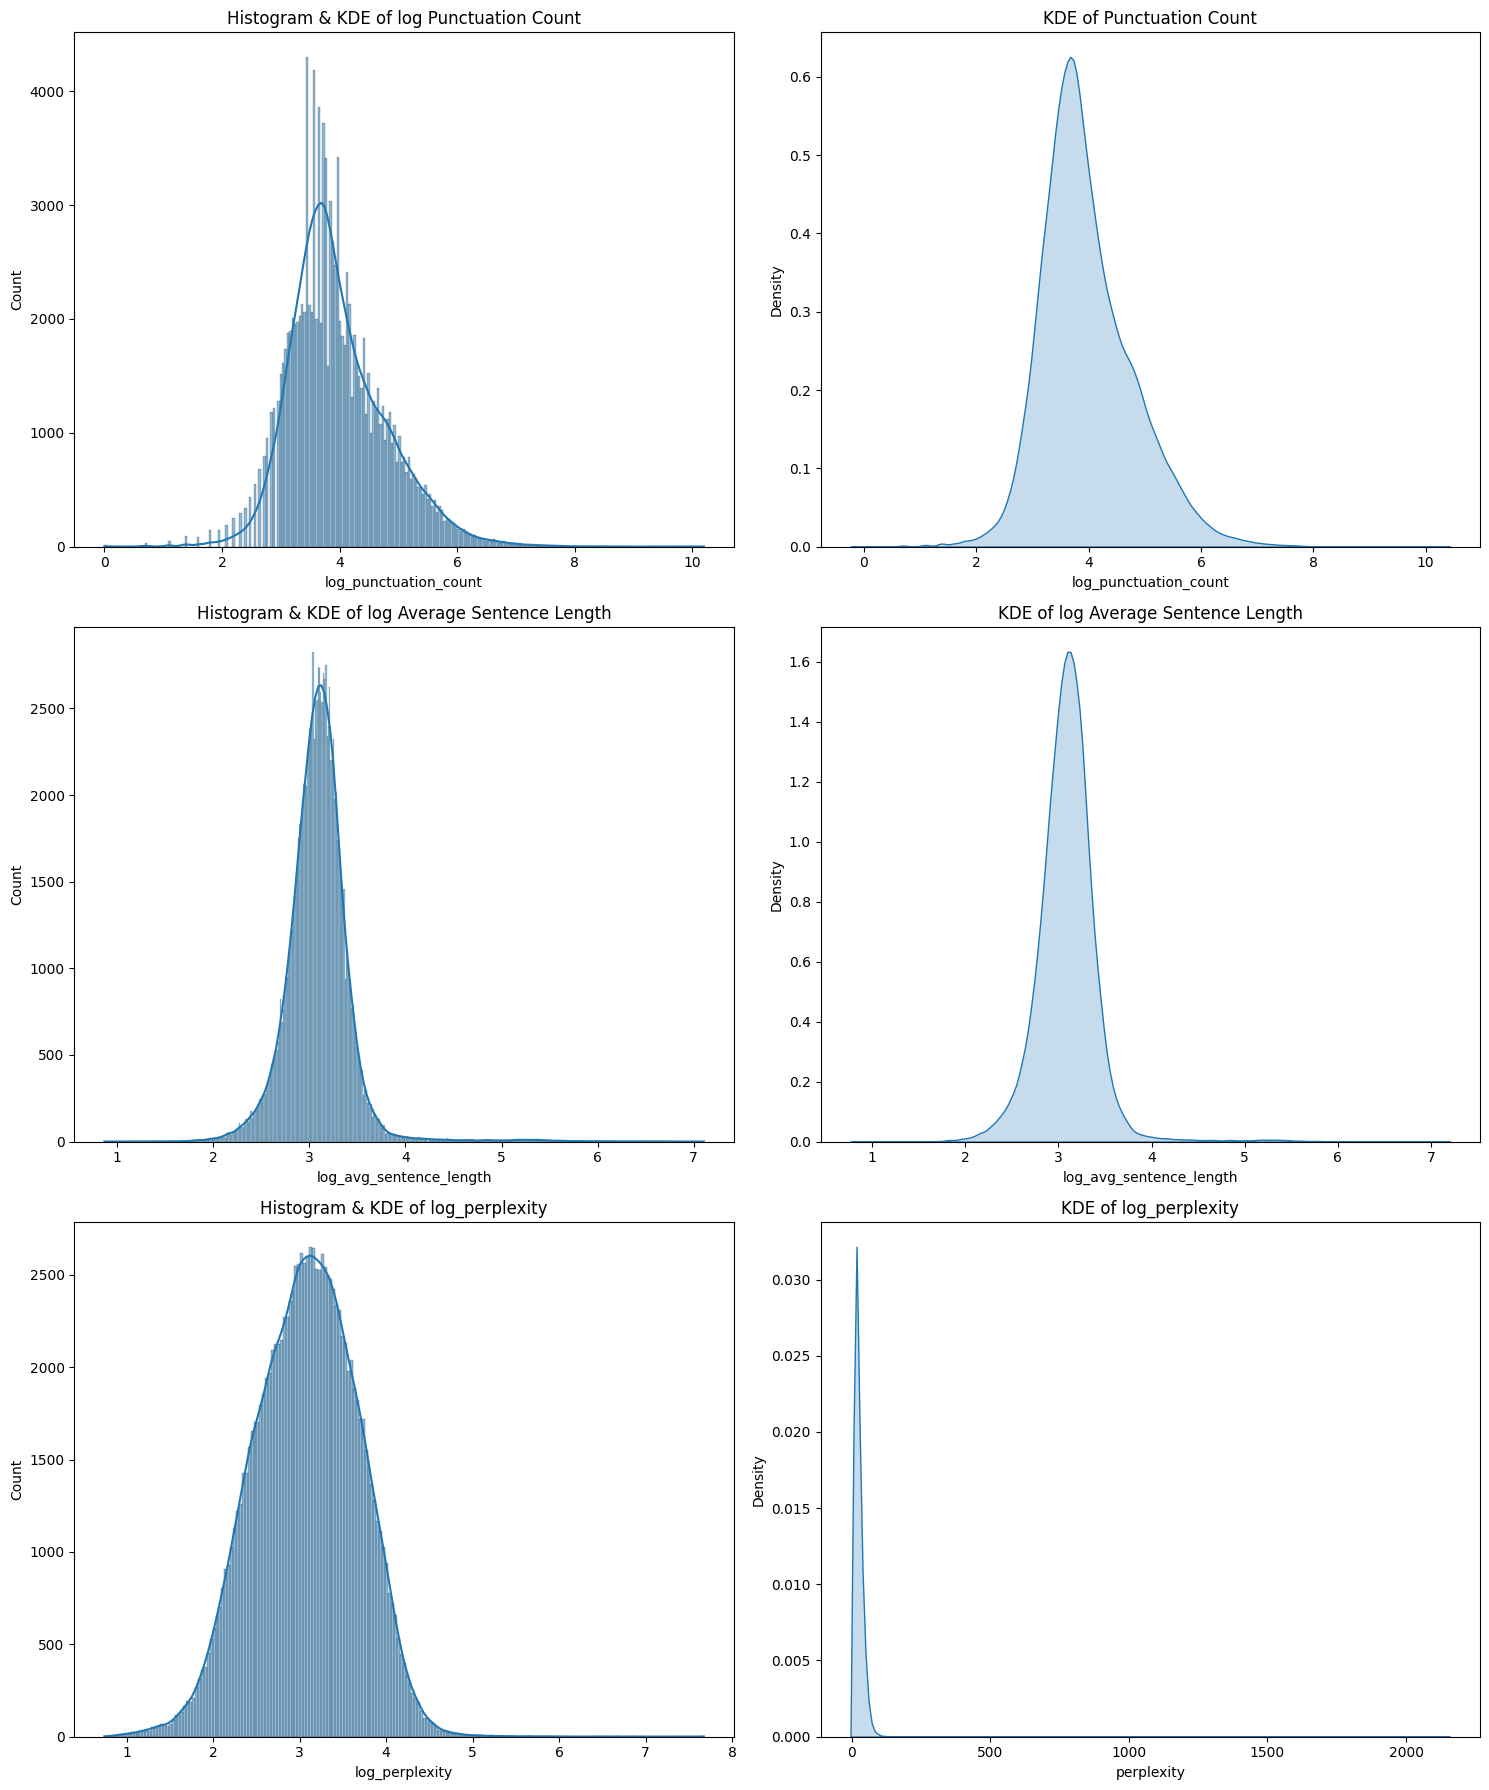

In [7]:
fig, axes = plt.subplots(3, 2, figsize=(15, 18))

# Punctuation Count
sns.histplot(train_df['log_punctuation_count'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Histogram & KDE of log Punctuation Count')

# Average Sentence Length
sns.histplot(train_df['log_avg_sentence_length'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Histogram & KDE of log Average Sentence Length')

# Perplexity
sns.histplot(train_df['log_perplexity'], kde=True, ax=axes[2, 0])
axes[2, 0].set_title('Histogram & KDE of log_perplexity')

# KDE plots
sns.kdeplot(train_df['log_punctuation_count'], ax=axes[0, 1], shade=True)
axes[0, 1].set_title('KDE of Punctuation Count')

sns.kdeplot(train_df['log_avg_sentence_length'], ax=axes[1, 1], shade=True)
axes[1, 1].set_title('KDE of log Average Sentence Length')

sns.kdeplot(train_df['perplexity'], ax=axes[2, 1], shade=True)
axes[2, 1].set_title('KDE of log_perplexity')

plt.tight_layout()
plt.show()

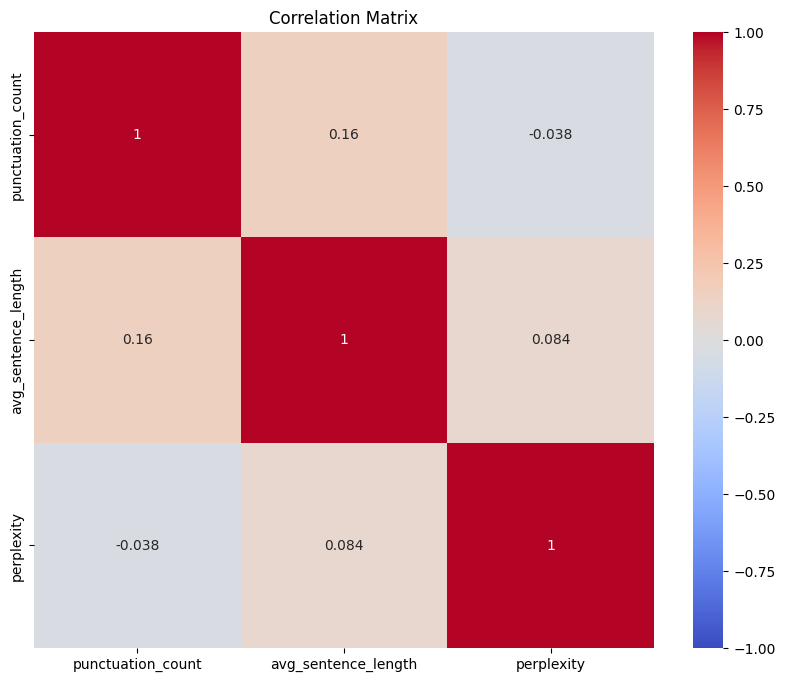

In [21]:
# Plot correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = train_df[['punctuation_count', 'avg_sentence_length', 'perplexity']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [8]:
train_df.head()

,text,label,model,source,id,punctuation_count,avg_sentence_length,perplexity,log_punctuation_count,log_avg_sentence_length,log_perplexity
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,0,82,11.305556,10.648826,4.418841,2.510051,2.455205
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,1,132,10.014706,7.353057,4.890349,2.399231,2.122628
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,2,153,10.144444,7.753972,5.036953,2.410941,2.169507
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,3,152,12.059701,7.754606,5.030438,2.569531,2.169580
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,4,89,13.547619,7.842487,4.499810,2.677427,2.179568


## Without Feature Engineering

In [10]:
# Split training data
X_train_wfe, X_val_wfe, y_train_wfe, y_val_wfe = train_test_split(train_df["text"], train_df["label"], test_size=0.2, random_state=42)

# Convert text to TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000, stop_words="english")
X_train__wfe_tfidf = vectorizer.fit_transform(X_train_wfe)
X_val_wfe_tfidf = vectorizer.transform(X_val_wfe)

# Train logistic regression model
baseline_model = LogisticRegression()
baseline_model.fit(X_train__wfe_tfidf, y_train_wfe)

# Evaluate the model
y_pred_wfe = baseline_model.predict(X_val_wfe_tfidf)
print("Baseline Accuracy:", accuracy_score(y_val_wfe, y_pred_wfe))
print(classification_report(y_val_wfe, y_pred_wfe))


Baseline Accuracy: 0.8827655310621243
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     12496
           1       0.89      0.87      0.88     11456

    accuracy                           0.88     23952
   macro avg       0.88      0.88      0.88     23952
weighted avg       0.88      0.88      0.88     23952



## After feature Extraction

In [11]:

# Define the features and target
X = train_df[['text', 'log_punctuation_count', 'log_avg_sentence_length', 'log_perplexity']]
y = train_df['label']

# Split the data into training and validation sets
X_train_fe, X_val_fe, y_train_fe, y_val_fe = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=10000, stop_words='english'), 'text'),
        ('num', StandardScaler(), ['log_punctuation_count', 'log_avg_sentence_length', 'log_perplexity'])
    ])

# Create a pipeline with the preprocessor and logistic regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Train the model
pipeline.fit(X_train_fe, y_train_fe)

# Evaluate the model
y_pred_fe = pipeline.predict(X_val_fe)
print("Accuracy:", accuracy_score(y_val_fe, y_pred_fe))
print(classification_report(y_val_fe, y_pred_fe))

Accuracy: 0.9283567134268537
              precision    recall  f1-score   support

           0       0.92      0.95      0.93     12496
           1       0.94      0.91      0.92     11456

    accuracy                           0.93     23952
   macro avg       0.93      0.93      0.93     23952
weighted avg       0.93      0.93      0.93     23952



In [ ]:
from xgboost import XGBClassifier

# Create a pipeline with the preprocessor and XGBoost model
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])

# Train the XGBoost model
xgb_pipeline.fit(X_train_fe, y_train_fe)

# Evaluate the XGBoost model
y_pred_xgb = xgb_pipeline.predict(X_val_fe)
print("XGBoost Accuracy:", accuracy_score(y_val_fe, y_pred_xgb))
print(classification_report(y_val_fe, y_pred_xgb))

/Users/devanshk/Desktop/CSI5386-NLP/nlp/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:48:52] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.937625250501002
              precision    recall  f1-score   support

           0       0.93      0.96      0.94     12496
           1       0.95      0.92      0.93     11456

    accuracy                           0.94     23952
   macro avg       0.94      0.94      0.94     23952
weighted avg       0.94      0.94      0.94     23952



##LSTM

In [2]:
from transformers import BertTokenizer, BertModel
import os

# Define model name and download directory
bert_model_name = "bert-base-uncased"
save_directory = "./bert_model/"

# Download the tokenizer and model manually
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name)

# Save the files to local directory
tokenizer.save_pretrained(save_directory)
bert_model.save_pretrained(save_directory)

print("BERT Model and Tokenizer saved successfully!")

/Users/devanshk/Desktop/CSI5386-NLP/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BERT Model and Tokenizer saved successfully!


In [20]:
from transformers import BertTokenizer, BertModel
import os
# Load Pretrained BERT Tokenizer & Model
bert_model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name).to(device)

y_label = np.array(train_df["label"])

# Tokenize Text Data Using BERT Tokenizer
def encode_texts(texts, tokenizer, max_length=100):
    encoded = tokenizer.batch_encode_plus(
        texts.tolist(),
        max_length=max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    return encoded["input_ids"], encoded["attention_mask"]



# Convert Text to BERT Token IDs and Attention Mask
X_input_ids, X_attention_mask = encode_texts(train_df["text"], tokenizer)
X_input_ids = X_input_ids.numpy()
X_attention_mask = X_attention_mask.numpy()

# Split Data into Train and Validation Sets
X_train_ids, X_val_ids, X_train_mask, X_val_mask, y_train_bertbilstm, y_val_bertbilstm = train_test_split(
    X_input_ids, X_attention_mask, y_label, test_size=0.2, random_state=42, stratify=y_label
)
y_train_bertbilstm = np.array(y_train_bertbilstm)
y_val_bertbilstm = np.array(y_val_bertbilstm)
# Define Custom Dataset for PyTorch
class TextDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = np.array(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create DataLoaders
batch_size = 16
train_dataset = TextDataset(X_train_ids, X_train_mask, y_train_bertbilstm)
val_dataset = TextDataset(X_val_ids, X_val_mask, y_val_bertbilstm)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# Define BERT + BiLSTM Model
class BertBiLSTM(nn.Module):
    def __init__(self, bert_model, hidden_dim=128, num_classes=2, dropout_rate=0.3):
        super(BertBiLSTM, self).__init__()
        self.bert = bert_model
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # BiLSTM has 2*hidden_dim output

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():  # Don't train BERT, use frozen embeddings
            bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
        
        hidden_states = bert_outputs.last_hidden_state  # (batch_size, sequence_length, hidden_dim)
        lstm_out, _ = self.lstm(hidden_states)  # (batch_size, sequence_length, hidden_dim*2)
        lstm_out = lstm_out[:, 0, :]  # Take output of first token (CLS token)
        lstm_out = self.dropout(lstm_out)
        logits = self.fc(lstm_out)  # Output layer
        return logits

In [22]:
# Instantiate Model
num_classes = len(set(y_label))
model = BertBiLSTM(bert_model, num_classes=num_classes).to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Training Loop
num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {train_acc:.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in val_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

val_acc = correct / total
print(f"Validation Accuracy: {val_acc:.4f}")

Epoch [1/3], Loss: 2760.5060, Accuracy: 0.7772
Epoch [2/3], Loss: 2158.9722, Accuracy: 0.8399
Epoch [3/3], Loss: 1970.7140, Accuracy: 0.8549
Validation Accuracy: 0.8361


In [ ]:
import pickle

# Define filename
model_filename = "bert_bilstm_model.pkl"

# Save model architecture & weights
with open(model_filename, "wb") as f:
    pickle.dump(model.state_dict(), f)

print(f"Model saved successfully as {model_filename}")


Model saved successfully as bert_bilstm_model.pkl


In [28]:
# Apply the count_punctuation function
test_df['punctuation_count'] = test_df['text'].apply(count_punctuation)

# Apply the avg_sentence_length function
test_df['avg_sentence_length'] = test_df['text'].apply(avg_sentence_length)

# Apply the calculate_perplexity function
test_df['perplexity'] = test_df['text'].apply(calculate_perplexity)

# Display the dataframe with the new columns
print(test_df.head())

                                                text  id  punctuation_count  \
0  Today, many adults or teenage drivers are hook...   0                 49   
1  The automobile, since its advent, has revoluti...   1                 59   
2   One policy that could potentially improve aca...   2                 56   
3  Title: Navigating the Road Ahead: The Case for...   3                 48   
4  Have you ever woken up in the morning and wish...   4                109   

   avg_sentence_length  perplexity  
0            15.903226   27.652035  
1            17.652174   24.311052  
2            28.500000   10.818463  
3            24.750000   28.325270  
4            19.039216   18.184008  


In [29]:
# Apply log transformation
test_df['log_punctuation_count'] = np.log1p(test_df['punctuation_count'])
test_df['log_avg_sentence_length'] = np.log1p(test_df['avg_sentence_length'])
test_df['log_perplexity'] = np.log1p(test_df['perplexity'])

# Display the dataframe with the new log-transformed columns
print(test_df[['log_punctuation_count', 'log_avg_sentence_length', 'log_perplexity']].head())

   log_punctuation_count  log_avg_sentence_length  log_perplexity
0               3.912023                 2.827504        3.355224
1               4.094345                 2.925963        3.231241
2               4.043051                 3.384390        2.469663
3               3.891820                 3.248435        3.378450
4               4.700480                 2.997691        2.954077


In [30]:
# Provide the file path for download
test_csv_path = "test_df.csv"
test_df.to_csv(test_csv_path, index=False)

In [33]:
# Fit the vectorizer on the training data
vectorizer.fit(train_df['text'])

# Transform the text data in test_df using the fitted vectorizer
test_tfidf = vectorizer.transform(test_df['text'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Display the TF-IDF DataFrame
print(tfidf_df.head())

    00  000   01   05   10  100  1000   11   12  120  ...  yield  yoga  york  \
0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0   0.0   0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0   0.0   0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0   0.0   0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0   0.0   0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0   0.0   0.0   

   young  younger  youth  youtube  zealand     zero  zone  
0    0.0      0.0    0.0      0.0      0.0  0.06035   0.0  
1    0.0      0.0    0.0      0.0      0.0  0.00000   0.0  
2    0.0      0.0    0.0      0.0      0.0  0.00000   0.0  
3    0.0      0.0    0.0      0.0      0.0  0.00000   0.0  
4    0.0      0.0    0.0      0.0      0.0  0.00000   0.0  

[5 rows x 5000 columns]


In [34]:
# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(test_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenate the TF-IDF features with the log-transformed features
new_test_df = pd.concat([tfidf_df, test_df[['log_punctuation_count', 'log_avg_sentence_length', 'log_perplexity']].reset_index(drop=True)], axis=1)

# Display the new dataframe
print(new_test_df.head())

    00  000   01   05   10  100  1000   11   12  120  ...  young  younger  \
0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0      0.0   
1  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0      0.0   
2  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0      0.0   
3  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0      0.0   
4  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  ...    0.0      0.0   

   youth  youtube  zealand     zero  zone  log_punctuation_count  \
0    0.0      0.0      0.0  0.06035   0.0               3.912023   
1    0.0      0.0      0.0  0.00000   0.0               4.094345   
2    0.0      0.0      0.0  0.00000   0.0               4.043051   
3    0.0      0.0      0.0  0.00000   0.0               3.891820   
4    0.0      0.0      0.0  0.00000   0.0               4.700480   

   log_avg_sentence_length  log_perplexity  
0                 2.827504        3.355224  
1                 2.925963        3.23

In [37]:
import jsonlines

# Ensure all entries in the 'text' column are strings
new_test_df['text'] = new_test_df['text'].fillna('').astype(str)

# Predict on the new test data
y_pred_new_test = xgb_pipeline.predict(new_test_df)

# Create a list of dictionaries with "id" and "label"
predictions = [{"id": int(id_), "label": int(label)} for id_, label in zip(test_df["id"], y_pred_new_test)]

# Define the output file path
output_file_path = "predictions.jsonl"

# Write the predictions to a JSONL file
with jsonlines.open(output_file_path, mode='w') as writer:
    writer.write_all(predictions)

print(f"Predictions saved to {output_file_path}")

Predictions saved to predictions.jsonl


In [ ]:

python3 scorer.py --gold_file_path=gold.jsonl --pred_file_path=predictions.jsonl